In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def predictAndGetAccuracyScore(model, x_valid, y_valid):
    y_pred = model.predict(x_valid)
    accuracy =  accuracy_score(y_valid, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return accuracy

In [3]:
def getRandomizedSearch(model, param_grid, x_train, y_train):
    grid = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy',
                              n_iter=2, random_state=42, verbose=2, n_jobs=-1)
    grid.fit(x_train, y_train)
    print("Best Hyperparameters:", grid.best_params_)
    return grid


In [4]:
# ### PCA
# def getMinVarWithAccuracy(model,comp_accuracy, x_train, x_valid, y_train, y_valid):
#     n_comp = 0.99
#     while 1:
#         pca = PCA(n_components=n_comp, svd_solver="full")
#         pca.fit(x_train)
#         model.fit(pca.transform(x_train), y_train)
#         accuracyNext = predictAndGetAccuracyScore(svm_model, pca.transform(x_valid), y_valid)
#         if accuracyNext < comp_accuracy:
#             break
#         else:
#             print("n_comp", n_comp, end=" ")
#             print("Accuracy", accuracyNext)
#             n_comp -= 0.01
#     return n_comp+0.01

# n = getMinVarWithAccuracy(svm_model,0.9, x_train["label_1"], x_valid["label_1"], y_train["label_1"], y_valid["label_1"])
# print(n)


In [5]:
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')

In [6]:
X_train = train_data.drop(columns=["label_1", "label_2", "label_3", "label_4"])
y_test_train = train_data["label_1"]

X_valid = valid_data.drop(columns=["label_1", "label_2", "label_3", "label_4"])
Y_valid = valid_data["label_1"]

X_test = valid_data.drop(columns=["label_1", "label_2", "label_3", "label_4"])
Y_test = valid_data["label_1"]

In [7]:
x_train = {}
x_valid = {}
y_train = {}
y_valid = {}
x_test = {}
y_test = {}
Labels = ["label_1", "label_2", "label_3", "label_4"]
Features = np.array(train_data.drop(columns=["label_1", "label_2", "label_3", "label_4"]).columns)

for label in Labels:
  tr_data = train_data[train_data["label_2"].notna()] if label == "label_2" else train_data
  vl_data = valid_data[valid_data["label_2"].notna()] if label == "label_2" else valid_data
  
  scaler = StandardScaler()
  
  x_train[label] = pd.DataFrame(scaler.fit_transform(tr_data.drop(Labels, axis=1)), columns=Features)
  y_train[label] = tr_data[label]
  x_valid[label] = pd.DataFrame(scaler.transform(vl_data.drop(Labels, axis=1)), columns=Features)
  y_valid[label] = vl_data[label]
  x_test[label] = pd.DataFrame(scaler.transform(test_data.drop(["ID"], axis=1)), columns=Features)


<h4>Label 1 - Speaker</h4>

In [8]:
###### Initial accuracy with svm_model
svm_model_1 = SVC(kernel="linear")
svm_model_1.fit(x_train["label_1"], y_train["label_1"])
accuracy_label_1 = predictAndGetAccuracyScore(svm_model_1, x_valid["label_1"], y_valid["label_1"])

Accuracy: 94.00%


In [9]:
#Apply PCA -Feature Extraction
pca_label_1 = PCA(n_components=0.99, svd_solver="full")
pca_label_1.fit(x_train["label_1"])
x_train_label_1_PCA = pd.DataFrame(pca_label_1.transform(x_train["label_1"]))
print(x_train_label_1_PCA.shape)
x_valid_label_1_PCA = pd.DataFrame(pca_label_1.transform(x_valid["label_1"]))


(28520, 572)


In [10]:
#Hyper parameter tuning
#Randomized search
param_dist = {
    'C': [100,10,1],  # Continuous uniform distribution for 'C'
    'kernel': ['rbf','linear'],  # Categorical distribution for 'kernel'
    'gamma': [0.001,0.01,0.1],
    # Add more hyperparameters and their distributions as needed
}

# Create a RandomizedSearchCV object
random_search_label_1 = getRandomizedSearch(svm_model_1, param_dist, x_train_label_1_PCA, y_train["label_1"])

# Get the best hyperparameters and the corresponding model
best_model_label_1 = random_search_label_1.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


In [11]:
# Evaluate the best model on your validation set
acc_best_model_label_1 = best_model_label_1.score(
    x_valid_label_1_PCA, y_valid["label_1"])

print("Validation Accuracy with Best Model:", acc_best_model_label_1)

Validation Accuracy with Best Model: 0.972


In [13]:
y_pred_label_1 = best_model_label_1.predict(pca_label_1.transform(x_test["label_1"]))

In [16]:
result_df = pd.DataFrame({'ID': test_data['ID'], 'label_1': y_pred_label_1})

In [15]:
# #Use tuned hyper parameters
# tuned_svm_model = SVC(kernel='rbf', gamma=0.001, C=100)
# tuned_svm_model.fit(x_train_label1_PCA, y_train["label_1"])
# acc = predictAndGetAccuracyScore(tuned_svm_model, x_valid_label1_PCA, y_valid["label_1"])

SVC(C=100, gamma=0.001)

   <h4>Label 2</h4>

In [15]:
###### Initial accuracy with svm_model
 
svm_model_2 = SVC()
svm_model_2.fit(x_train["label_2"], y_train["label_2"])
acc = predictAndGetAccuracyScore(svm_model_2, x_valid["label_2"], y_valid["label_2"])


Accuracy: 90.08%


In [17]:
#Apply PCA - Feature Extraction
pca_label_2 = PCA(n_components=0.96, svd_solver="full")
pca_label_2.fit(x_train["label_2"])
x_train_label2_PCA = pd.DataFrame(pca_label_2.transform(x_train["label_2"]))
print(x_train_label2_PCA.shape)
x_valid_label2_PCA = pd.DataFrame(pca_label_2.transform(x_valid["label_2"]))


(28040, 352)


In [18]:
svm_model_2.fit(x_train_label2_PCA, y_train["label_2"])
acc = predictAndGetAccuracyScore(svm_model_2, x_valid_label2_PCA, y_valid["label_2"])

Accuracy: 89.13%


In [19]:
#Hyper parameter tuning
#Randomized search
param_dist = {
    # Continuous uniform distribution for 'C'
    'C': [100, 10, 1, 0.1],
    'kernel': ['rbf'],  # Categorical distribution for 'kernel'
    'gamma': [0.001, 0.01, 0.1, 1,],
    # Add more hyperparameters and their distributions as needed
}
random_search = getRandomizedSearch(svm_model_2, param_dist, x_train_label2_PCA, y_train["label_2"])
best_model_label_2 = random_search.best_estimator_


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


In [20]:
acc_best_model_label_2 = predictAndGetAccuracyScore(best_model_label_2, x_valid_label2_PCA, y_valid["label_2"]) 

Accuracy: 91.85%


In [87]:
# # Since Accuracy has decrease after randomized search, manual search was used and got best parameters as 
# # C=10, gamma=0.001 and kernel=rbf

# svm_model_2_tuned = SVC(kernel= 'rbf', gamma= 0.001, C= 10)
# svm_model_2_tuned.fit(x_train_label2_PCA, y_train["label_2"])
# acc_best_model_tuned_label_2 = predictAndGetAccuracyScore(svm_model_2_tuned, x_valid_label2_PCA, y_valid["label_2"])


Accuracy: 91.71%


In [21]:
y_pred_label_2 = best_model_label_2.predict(pca_label_2.transform(x_test["label_2"]))

In [22]:
result_df['label_2'] = y_pred_label_2

<h4>Label 3</h4>

In [23]:
###### Initial accuracy with svm_model
svm_model_3 = SVC(kernel="linear")
svm_model_3.fit(x_train["label_3"], y_train["label_3"])
acc = predictAndGetAccuracyScore(svm_model_3, x_valid["label_3"], y_valid["label_3"])


Accuracy: 99.73%


In [31]:
#Apply PCA - Feature Extraction
pca_label_3 = PCA(n_components=0.85, svd_solver="full")
pca_label_3.fit(x_train["label_3"])
x_train_label_3_PCA = pd.DataFrame(pca_label_3.transform(x_train["label_3"]))
print(x_train_label_3_PCA.shape)
x_valid_label_3_PCA = pd.DataFrame(pca_label_3.transform(x_valid["label_3"]))


(28520, 120)


In [32]:
svm_model_3.fit(x_train_label_3_PCA, y_train["label_3"])
acc = predictAndGetAccuracyScore(svm_model_3, x_valid_label_3_PCA, y_valid["label_3"])

Accuracy: 99.07%


In [33]:
#Hyper parameter tuning
#Randomized search

label_3_param_dist = {
    # Continuous uniform distribution for 'C'
    'C': [100, 10, 1, 0.1],
    'kernel': ['rbf'],  # Categorical distribution for 'kernel'
    'gamma': [0.001, 0.01, 0.1, 1],
    # Add more hyperparameters and their distributions as needed
}

In [34]:
random_search_label_3 = getRandomizedSearch(svm_model_3, label_3_param_dist, x_train_label_3_PCA, y_train["label_3"])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


In [35]:
best_model_label_3 = random_search_label_3.best_estimator_
acc_best_model_label_3 = predictAndGetAccuracyScore(best_model_label_3, x_valid_label_3_PCA, y_valid["label_3"])

Accuracy: 99.60%


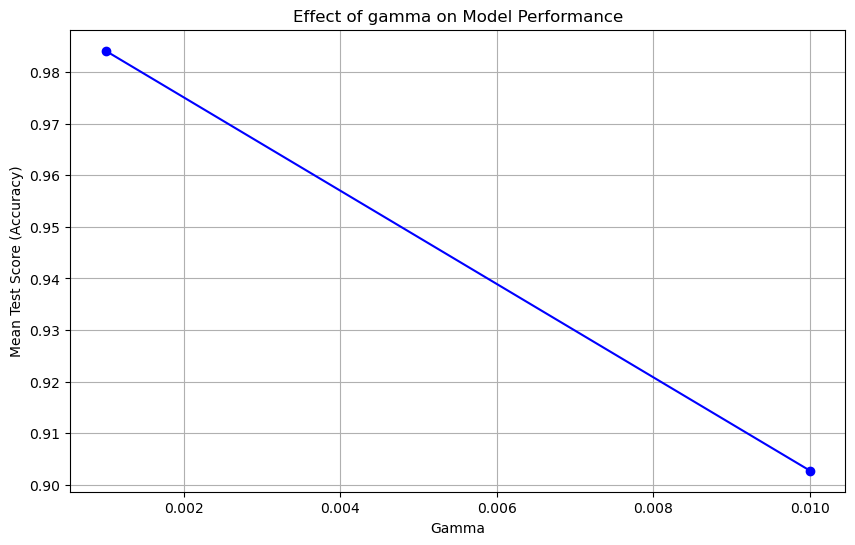

In [36]:
import matplotlib.pyplot as plt

# Access the results of the randomized search
results = random_search_label_3.cv_results_

# Extract the hyperparameters and their corresponding scores
param_gamma = results['param_gamma'].data
mean_test_scores = results['mean_test_score']

# Create a plot to visualize the relationship between C and mean test scores
plt.figure(figsize=(10, 6))
plt.plot(param_gamma, mean_test_scores, marker='o', linestyle='-', color='b')
plt.title('Effect of gamma on Model Performance')
plt.xlabel('Gamma')
plt.ylabel('Mean Test Score (Accuracy)')
plt.grid(True)
plt.show()


In [37]:
y_pred_label_3 = best_model_label_3.predict(pca_label_3.transform(x_test["label_3"]))

In [38]:
result_df['label_3'] = y_pred_label_3

<h4>Label 4</h4>

In [39]:
###### Initial accuracy with svm_model
svm_model_4 = SVC()
svm_model_4.fit(x_train["label_4"], y_train["label_4"])
acc = predictAndGetAccuracyScore(
    svm_model_4, x_valid["label_4"], y_valid["label_4"])


Accuracy: 93.87%


In [40]:
pca_label_4 = PCA(n_components=0.91, svd_solver="full")
pca_label_4.fit(x_train["label_4"])
x_train_label_4_PCA = pd.DataFrame(pca_label_4.transform(x_train["label_4"]))
print(x_train_label_4_PCA.shape)
x_valid_label_4_PCA = pd.DataFrame(pca_label_4.transform(x_valid["label_4"]))


(28520, 203)


In [41]:
svm_model_4.fit(x_train_label_4_PCA, y_train["label_4"])
acc = predictAndGetAccuracyScore(svm_model_4, x_valid_label_4_PCA, y_valid["label_4"])

Accuracy: 93.07%


In [42]:
label_4_param_dist = {
    # Continuous uniform distribution for 'C'
    'C': [100, 10, 1, 0.1],
    'kernel': ['rbf'],  # Categorical distribution for 'kernel'
    'gamma': [0.001, 0.01, 0.1, 1],
    # Add more hyperparameters and their distributions as needed
}

In [43]:
random_search_label_4 = getRandomizedSearch(svm_model_4, label_4_param_dist, x_train_label_4_PCA, y_train["label_4"])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


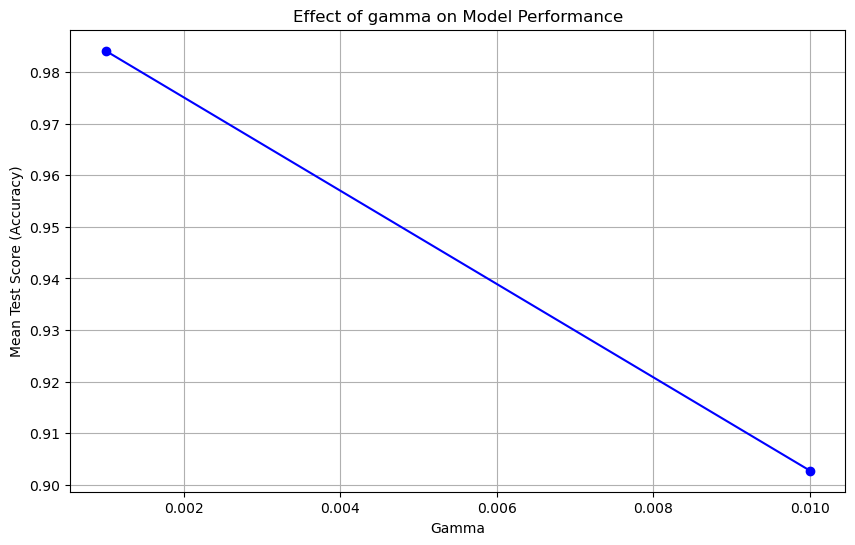

In [44]:
import matplotlib.pyplot as plt

# Access the results of the randomized search
results = random_search_label_3.cv_results_

# Extract the hyperparameters and their corresponding scores
param_gamma = results['param_gamma'].data
mean_test_scores = results['mean_test_score']

# Create a plot to visualize the relationship between C and mean test scores
plt.figure(figsize=(10, 6))
plt.plot(param_gamma, mean_test_scores, marker='o', linestyle='-', color='b')
plt.title('Effect of gamma on Model Performance')
plt.xlabel('Gamma')
plt.ylabel('Mean Test Score (Accuracy)')
plt.grid(True)
plt.show()


In [45]:
best_model_label_4 = random_search_label_4.best_estimator_

acc_best_model_label_4 = predictAndGetAccuracyScore(best_model_label_4, x_valid_label_4_PCA, y_valid["label_4"])

Accuracy: 96.13%


In [46]:
y_pred_label_4 = best_model_label_4.predict(pca_label_4.transform(x_test["label_4"]))

In [47]:
result_df['label_4'] = y_pred_label_4

In [48]:
result_df.to_csv("solutions.csv", index=False)